In [ ]:
import pandas as pd
import os
ROOT = os.getcwd()
import seaborn as sns
import nltk
nltk.download('stopwords')
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter
import contractions
import numpy as np

import torchtext
import textblob

import re

from tqdm import tqdm

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import pickle

import random


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamesnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TWEET140_PATH = os.path.join(ROOT, 'dataset', 'tweet140.csv')
assert os.path.exists(TWEET140_PATH), 'path to dataset not found'

In [3]:
#link: https://www.kaggle.com/code/abdoashraf90/twitter-sentiment-analysis
df = pd.read_csv(TWEET140_PATH, encoding="ISO-8859-1", names= ["target", "id", "date", "flag", "user", "text"])
print(df.shape)

df.drop(['id', 'date', 'flag', 'user'], axis = 1, inplace=True)
df.head()

(1600000, 6)


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Target has 2 values: 0 - negative, 4 - positive, o
# we want to convert 4 to 1 to make it conventional

df['target'][df['target'] == 4] = 1

/var/folders/_s/m9kt_szd4qq9brspl9hd44mc0000gn/T/ipykernel_58897/3054085162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][df['target'] == 4] = 1


# EDA

target
0    800000
1    800000
Name: count, dtype: int64


<Axes: ylabel='count'>

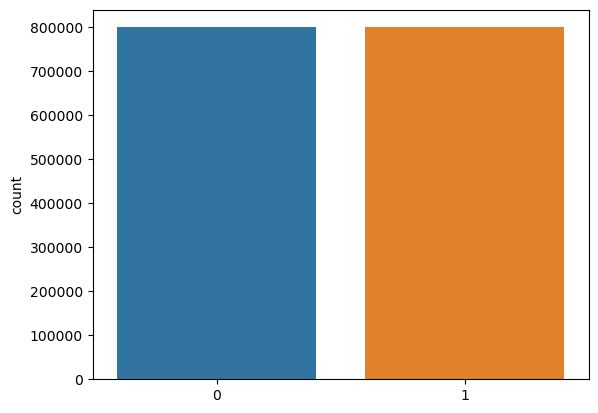

In [5]:
print(df['target'].value_counts())
sns.countplot(x = df['target'].values)

In [6]:
alltext = ' '.join(df['text'].values)
print(len(alltext))
print(alltext[:10])

120144177
@switchfoo


In [7]:
# wc = WordCloud(width=1600, height = 800)
# wc.generate(alltext)
# plt.imshow(wc)
# plt.show()


# Detect non-english words or rubbish

In [8]:
# words = alltext.split()

# lang = textblob.TextBlob()

# print(lang('something'))
# counter= Counter(words)

# with open('tweets140_words.txt', 'w') as file:
#     for k,v in counter.most_common():
#         file.write(f'{k}\n')


# Length and target correlation

In [9]:
df['length'] = df['text'].apply(lambda x: len(x))

In [10]:
df.head()

,target,text,length
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


In [11]:
print(df['target'].unique())

[0 1]


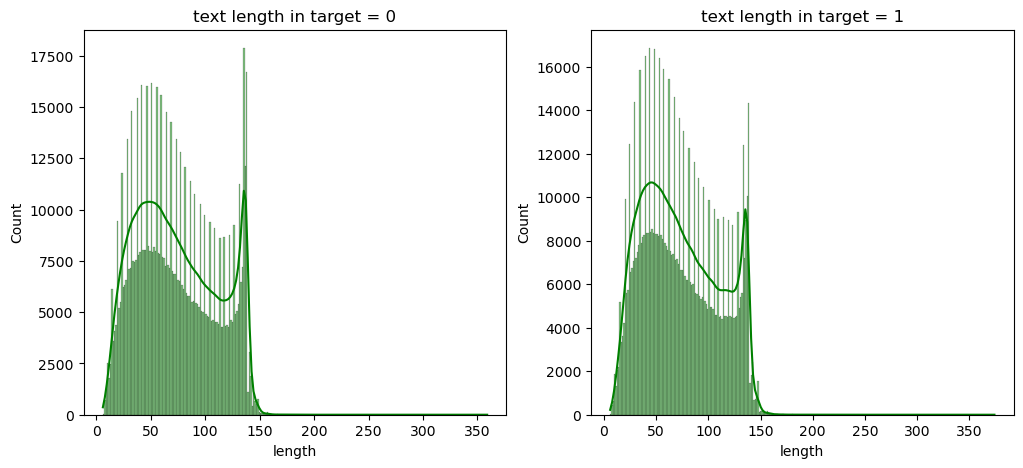

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
sns.histplot(data = df[df['target'] == 0], x = 'length', color = 'green', kde=True, ax = ax1)
ax1.set_title('text length in target = 0')
sns.histplot(data = df[df['target'] == 1], x = 'length', color = 'green', kde=True, ax = ax2)
ax2.set_title('text length in target = 1')
plt.show()

# clean text
- @something, starts with @
- https, web link wwww
- #hastag
- email
- non-latin symbols

In [13]:
def remove_urls(text):
    pattern =r"(http?\://|https?\://|www)\S+"
    return re.sub(pattern, ' ', text)

def remove_hashtags(text):
    pattern = r"#\S+"
    return re.sub(pattern, ' ', text)

def remove_mentions(text):
    pattern =r"(?:\@)\S+"
    return re.sub(pattern, ' ', text)

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text):
    return re.sub('[^A-Za-z]+', ' ', text)


def clean_text(text):
    text = text.lower()
    text = remove_urls(text)
    text = remove_hashtags(text)
    text = remove_mentions(text)
    text = expand_contractions(text)
    text = remove_special_characters(text)
    return text


text = "link https://www.example.com and web http://subdomain.example.org. hashtag #something and mention @wooho"
print(remove_urls(text))
print(remove_hashtags(text))
print(remove_mentions(text))
print(clean_text(text))

text = "??you're a123., onderful men!!!"
print(clean_text(text))


link   and web   hashtag #something and mention @wooho
link https://www.example.com and web http://subdomain.example.org. hashtag   and mention @wooho
link https://www.example.com and web http://subdomain.example.org. hashtag #something and mention  
link and web hashtag and mention 
 you are a onderful men 


In [14]:
df['text'] = df['text'].apply(clean_text)
df['length'] = df['text'].apply(lambda x: len(x))


In [15]:
df.head()

,target,text,length
0,0,a that is a bummer you shoulda got david carr...,70
1,0,is upset that he cannot update his facebook by...,107
2,0,i dived many times for the ball managed to sa...,74
3,0,my whole body feels itchy and like its on fire,47
4,0,no it is not behaving at all i am mad why am ...,93


In [16]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

def tokenize(text, tokenizer):
    return tokenizer(text)

tokens = tokenize('    - a  that is a bummer.  you shoulda got david carr of third day to do it. ;d', tokenizer)
print(tokens)



['-', 'a', 'that', 'is', 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', 'd']


In [17]:
text_data = df['text'].values
tokens = []
labels = df['target'].values

for text in tqdm(text_data):
    tokens.append(tokenize(text, tokenizer))

print(tokens[:10])
print(len(tokens))
print(labels[:10])
print(len(labels))





100%|██████████| 1600000/1600000 [00:12<00:00, 132929.28it/s]

[['a', 'that', 'is', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd'], ['is', 'upset', 'that', 'he', 'cannot', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', 'blah'], ['i', 'dived', 'many', 'times', 'for', 'the', 'ball', 'managed', 'to', 'save', 'the', 'rest', 'go', 'out', 'of', 'bounds'], ['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire'], ['no', 'it', 'is', 'not', 'behaving', 'at', 'all', 'i', 'am', 'mad', 'why', 'am', 'i', 'here', 'because', 'i', 'cannot', 'see', 'you', 'all', 'over', 'there'], ['not', 'the', 'whole', 'crew'], ['need', 'a', 'hug'], ['hey', 'long', 'time', 'no', 'see', 'yes', 'rains', 'a', 'bit', 'only', 'a', 'bit', 'lol', 'i', 'am', 'fine', 'thanks', 'how', 'is', 'you'], ['nope', 'they', 'did', 'not', 'have', 'it'], ['que', 'me', 'muera']]
1600000
[0 0 0 0 0 0 0 0 0 0]
1600000


# Building vocab

In [18]:
vocab = torchtext.vocab.build_vocab_from_iterator(tokens, min_freq = 5, specials = ['<unk>', '<pad>'])

In [19]:
print(vocab.get_itos()[:10])

['<unk>', '<pad>', 'i', 'to', 'the', 'a', 'is', 'you', 'my', 'it']


In [20]:
unk_index = vocab['<unk>']
print('unk index = ', unk_index)
pad_index = vocab['<pad>']
print('pad index = ', pad_index)
#set default index
vocab.set_default_index(unk_index)
print(vocab.lookup_indices(['something','is', 'not', 'okay', 'this should not be found']))

with open('vocab.txt', 'w') as file:
    for item in vocab.get_itos():
        file.write(item + '\n')

unk index =  0
pad index =  1
[190, 6, 11, 325, 0]


In [21]:
train_df = df.copy()
print(train_df.shape)
train_df.head()

(1600000, 3)


,target,text,length
0,0,a that is a bummer you shoulda got david carr...,70
1,0,is upset that he cannot update his facebook by...,107
2,0,i dived many times for the ball managed to sa...,74
3,0,my whole body feels itchy and like its on fire,47
4,0,no it is not behaving at all i am mad why am ...,93


In [22]:
print(tokens[0])
print(vocab(tokens[0]))

['a', 'that', 'is', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd']
[5, 17, 6, 5, 1132, 7, 3368, 43, 802, 9264, 15, 1806, 35, 3, 21, 9, 261]


In [23]:
max_len = 0
for token in tokens:
    max_len = max(len(token), max_len)

print(max_len)


53


In [24]:
def get_data(features, labels, vocab):
    X = []
    y = []
    valid_lens = []
    for i, feature in enumerate(tqdm((features))):
        X.append(torch.tensor(vocab(feature)))
        y.append(torch.tensor(labels[i]))
        valid_lens.append(torch.tensor(len(feature)))

    return X,y,valid_lens

X,y,valid_lens = get_data(tokens, labels, vocab)


100%|██████████| 1600000/1600000 [01:19<00:00, 20155.25it/s]


AttributeError: 'list' object has no attribute 'shape'

In [26]:
X = pad_sequence(X, batch_first=True, padding_value = pad_index)
y = torch.tensor(y)
valid_lens = torch.tensor(valid_lens)

In [29]:
print('X shape = ', X.shape)
print('y shape = ', y.shape)
print('valid_lens shape = ', valid_lens.shape)

X shape =  torch.Size([1600000, 53])
y shape =  torch.Size([1600000])
valid_lens shape =  torch.Size([1600000])


# Save tensor to save time from processing from scratch

In [37]:
TENSOR_DATA_PATH = os.path.join(ROOT, 'output')
if os.path.exists(TENSOR_DATA_PATH) == False: 
    os.makedirs(TENSOR_DATA_PATH)

torch.save(X, os.path.join(TENSOR_DATA_PATH, 'X.torch'))
torch.save(y, os.path.join(TENSOR_DATA_PATH, 'y.torch'))
torch.save(valid_lens, os.path.join(TENSOR_DATA_PATH, 'valid_lens.torch'))

# Why we need valid lens and pack_padded_sequence

pack_padded_sequence prevents useless computations because of the padded sequence

https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch

In [ ]:
test = [torch.random(random.randint(1,10)) for _ in range(10)] 
valid_lens = [len(x) for x in test] 
print(test)

test = pad_sequence(test)
print(test.shape)

pack_test = pack_padded_sequence(test, valid_lens, batch_first=True, enforce_sorted=False)
print(pack_test)

# Load GloVe Embedding

In [41]:
glove_vectors = torchtext.vocab.GloVe(name='6B')

.vector_cache/glove.6B.zip: 862MB [15:04, 953kB/s]                                


# LSTM model

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        vocab_size, 
        embedding_size,
        hidden_size,
        num_layers,
        bidirectional,
        output_size, 
        n_layers,
        pad_index,
        dropout = 0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout = dropout,
            batch_first=True
        )
        self.fc = nn.LazyLinear(output_size)
    
    def forward(self, X, valid_lens):
        embedded = self.embedding(X)
        #using pack_padded_sequence to optimize computations in large datasets

        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, valid_lens, batch_first=True, enforce_sorted=False
        )

        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        return None

cls = LSTMClassifier()        

sample_X = torch.randint(0,1000, (5, 10))
sample_valid_lens = [random.randint(3,10) for _ in range(5)]
cls(X)



